#**Voting**#

Realizo los importes necesarios.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

Descafgamos los dataframes.

In [ ]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

Realizamos el tratado de datos necesarios.

In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

In [ ]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

In [ ]:
variables_categoricas = ['country', 'agent', 'company', 'arrival_date_month', 'market_segment', 'distribution_channel', 'arrival_date_year', 
                         'hotel', 'meal', 'customer_type', 'assigned_room_type', 'deposit_type', 'reserved_room_type']

for variable in variables_categoricas:
  cambiar_columna_por_probabilidad_is_canceled(variable)

Realizamos el Voting con arbol de decisión, random forest, y regresión logistica.

Accuracy: 0.849
Precision: 0.861
Recall: 0.834
F1 score: 0.847


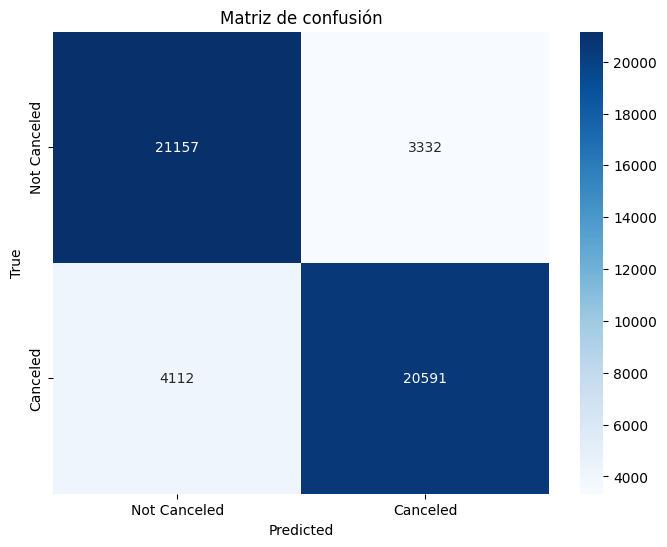

Accuracy: 0.850
Precision: 0.860
Recall: 0.834
F1 score: 0.847


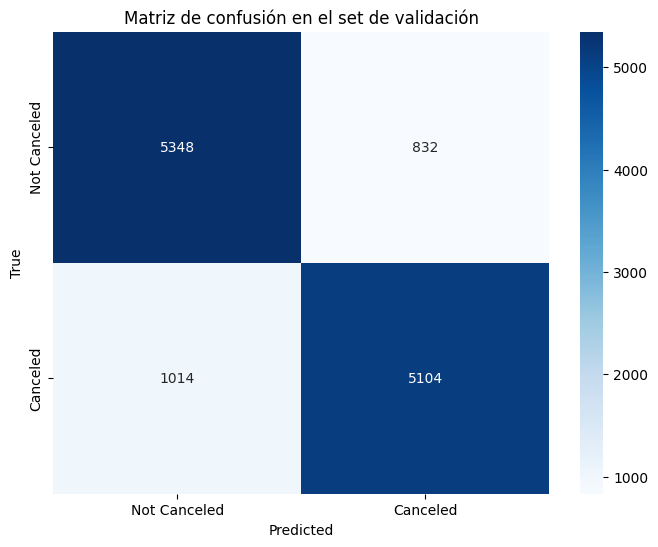

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_hotel.drop('is_canceled', axis=1), df_hotel['is_canceled'], test_size=0.2, random_state=42)

model1 = DecisionTreeClassifier(max_depth=5, random_state=42)
model2 = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
model3 = LogisticRegression(max_iter=10000, random_state=42)

ensemble = VotingClassifier(estimators=[('dt', model1), ('rf', model2), ('lr', model3)], voting='hard')

y_train_pred = cross_val_predict(ensemble, X_train, y_train, cv=5)

accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
conf_mat = confusion_matrix(y_train, y_train_pred)
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])
plt.show()

ensemble.fit(X_train, y_train)
y_val_pred = ensemble.predict(X_val)

print("Accuracy: {:.3f}".format(accuracy_score(y_val, y_val_pred)))
print("Precision: {:.3f}".format(precision_score(y_val, y_val_pred)))
print("Recall: {:.3f}".format(recall_score(y_val, y_val_pred)))
print("F1 score: {:.3f}".format(f1_score(y_val, y_val_pred)))
conf_mat = confusion_matrix(y_val, y_val_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Matriz de confusión en el set de validación')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])
plt.show()

Descargamos el modelo y realizamos la prediccion correspondiente.

In [ ]:
joblib.dump(ensemble, 'modelo_voting_final.pkl')
loaded_model = joblib.load('modelo_voting_final.pkl')
predicciones = loaded_model.predict(df_hotel_test)

In [ ]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('modelo_voting_final.csv', index=False)